In [1]:
import numpy as np
import pandas as pd
import numpy.random as rnd
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib import style,rcParams
from seaborn import regplot
from scipy.stats import linregress
style.use('default')
rcParams.update({'axes.grid': True})
rcParams.update({'errorbar.capsize': 2})
pd.options.display.float_format = '{:,.3f}'.format
#style.use('dark_background')
#style.use('default')
import ipywidgets as ipyw
import qgrid

In [2]:
#variables
#Km = 12.3
#Vmax = 86.1
Km = 1
Vmax = 2
smin = 1
smax = 60
step = 5
nrepl = 3
npoints = 10
std_dev = 0.01
err_type = "absolut"
outl_prob = 0.0
generate_data = True


In [3]:
# Michaelis-Menten equation
def MM(K,V,s):
  return V*s/(K+s)

In [4]:
if generate_data:
    s = np.linspace(0.2*Km,3.0*Km,npoints)
    v = np.zeros((len(s),nrepl))
    for i in range(nrepl):
       v[:,i] = MM(Km,Vmax,s)
    err = rnd.normal(0,std_dev,v.shape)
    if err_type == "absolut":
        v = v + err
    else:
       v = v * err
    from sys import stdout
    np.savetxt(stdout, np.hstack([s.reshape(-1,1),v]),fmt=" %5.2f ")
    

  0.20    0.33    0.33    0.34 
  0.51    0.67    0.68    0.67 
  0.82    0.90    0.92    0.88 
  1.13    1.08    1.06    1.07 
  1.44    1.18    1.18    1.18 
  1.76    1.26    1.26    1.26 
  2.07    1.35    1.34    1.35 
  2.38    1.40    1.42    1.41 
  2.69    1.46    1.45    1.46 
  3.00    1.50    1.51    1.51 


In [5]:
# Function to validate input by data type
def check_input(f_type,message):
    """
Wrapper around the input function, reads input
until it matches the required data type. 
    """
    flag = True
    while flag:
        value = input(message)
        try:
            value = f_type(value)
            flag = False
        except ValueError:
            pass
    return value

In [6]:
# Read the number of points and replicates
if not generate_data:
    npoints = check_input(int,"Number of points? ")
    nrepl = check_input(int,"Number of replicates? ")

In [7]:
# create an empy pandas data frame with the
# npoint lines and nrepl+1 columns
# enz_data.iloc[:,1:4].mean(axis=1)
# enz_data.iloc[:,1:4].std(axis=1)
#
columns = ['[A]']
columns = columns + ['v'+str(i+1) for i in range(nrepl)]
if generate_data: # fill data frame with generated data
    enz_data = pd.DataFrame(np.hstack([s.reshape(-1,1),v]),columns=columns)
else: # create an empty dataframe
    enz_data = pd.DataFrame(np.zeros((npoints, nrepl+1)),columns=columns)
# Create a qgrid table to input the data
qgrid_widget = qgrid.show_grid(enz_data, show_toolbar=False)
qgrid_widget.layout = ipyw.Layout(width='50%')
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [8]:
enz_data = qgrid_widget.get_changed_df()
enz_data['Mean v']=enz_data.iloc[:,1:].mean(axis=1)
enz_data['Std v']=enz_data.iloc[:,1:-1].std(axis=1)
#enz_data['fit_error']=enz_data['Mean v']-MM(Km,Vmax,enz_data['[A]'])
enz_data

,[A],v1,v2,v3,Mean v,Std v
0,0.200,0.329,0.327,0.343,0.333,0.009
1,0.511,0.670,0.681,0.675,0.675,0.006
2,0.822,0.898,0.921,0.878,0.899,0.021
3,1.133,1.077,1.059,1.070,1.069,0.009
4,1.444,1.185,1.179,1.184,1.183,0.003
5,1.756,1.260,1.257,1.256,1.257,0.002
6,2.067,1.355,1.338,1.348,1.347,0.008
7,2.378,1.402,1.416,1.414,1.411,0.008
8,2.689,1.459,1.455,1.458,1.457,0.002
9,3.000,1.501,1.505,1.512,1.506,0.005


In [9]:
# Get concentrations and velocities from the dataframe
v = np.array(enz_data.iloc[:,1:-2])
s = np.array(enz_data['[A]'])

In [10]:
# # create a pandas data frame with the data
# # also works:
# # enz_data.iloc[:,1:4].mean(axis=1)
# # enz_data.iloc[:,1:4].std(axis=1)
# #
# columns = ['[A]']
# columns = columns + ['v'+str(i+1) for i in range(nrepl)]
# enz_data = pd.DataFrame(np.hstack([s.reshape(-1,1),v]),columns=columns)
# enz_data['Mean v']=enz_data[columns[1:]].mean(axis=1)
# enz_data['Std v']=enz_data[columns[1:]].std(axis=1)
# enz_data['fit_error']=enz_data['Mean v']-MM(Km,Vmax,enz_data['[A]'])
# enz_data

In [11]:
# Create a pandas dataframa for storing the various estimates
df_estimates = pd.DataFrame(np.zeros((2,4)),index = ['Km','Vmax'],columns=['True','L-B','H-W','E-CB'])
if generate_data:
    df_estimates['True'] = Km,Vmax
else:
    df_estimates['True'] = Nan, Nan
df_estimates

,True,L-B,H-W,E-CB
Km,1,0.000,0.000,0.000
Vmax,2,0.000,0.000,0.000


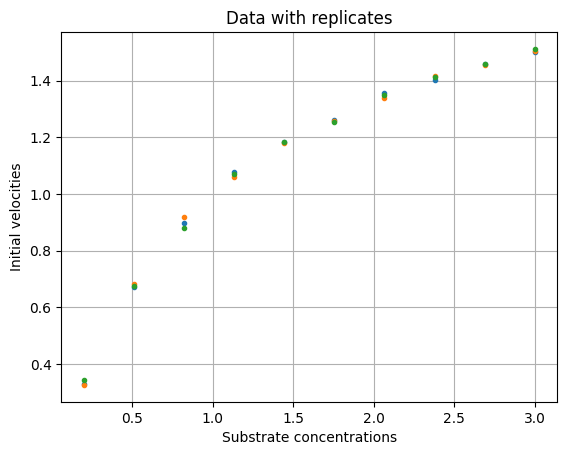

In [12]:
# Untransformed data with replicates
plt.title("Data with replicates")
plt.xlabel("Substrate concentrations")
plt.ylabel("Initial velocities")
#plt.ylim(0,1.1*Vmax)
plt.plot(s,v,'.');

In [13]:
# plt.plot('[A]','Mean v','r.',data=enz_data,label="data")
# sz = np.arange(0,s.max(),0.01)
# plt.plot(sz,MM(Km,Vmax,sz),'k--',label="True (Km={},Vmax={})".format(Km,Vmax))
# plt.title("Mean of generated data $\mathit{versus}$ true values")
# plt.xlabel("Substrate concentration")
# plt.ylim(0,1.1*Vmax)
# plt.ylabel("Initial velocity")
# plt.legend()
# #plt.plot(s,v,'k.')

Text(0.5, 1.0, 'Michaelis-Menten Plot with error bars')

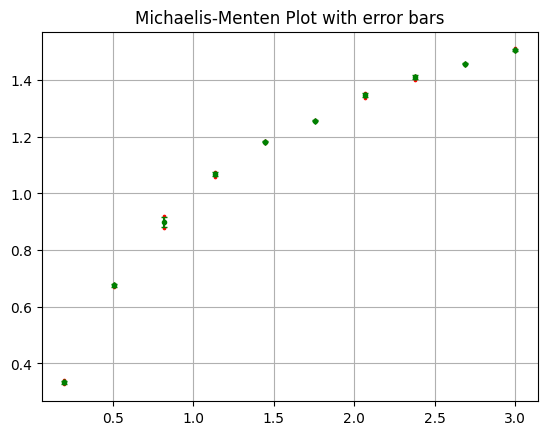

In [14]:
# Michaelis-Menten direct plot with error bars
plt.plot(s,v,'r.',ms=3.3)
plt.errorbar(s,v.mean(axis=1),fmt='g.',xerr=0.0,yerr=v.std(axis=1),capsize=2)
plt.title("Michaelis-Menten Plot with error bars")

Lineweaver-Burke estimates:
    Km = 1.001, Vmax= 1.999, R2 = 1.0000


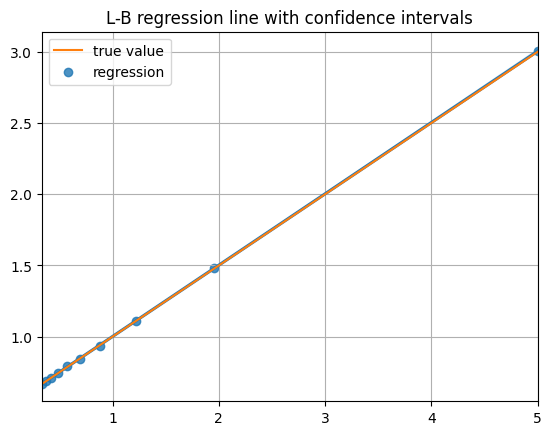

In [15]:
# Lineweaver-Burke regression with confidence intervals
from seaborn import regplot
vlb = v[:,0]
vlb = v.mean(axis=1)
regplot(1/s,1/vlb,label="regression")
m, b,r,_,_ = linregress(1/s,1/vlb)
_ = plt.title("L-B regression line with confidence intervals")
if generate_data:
    plt.plot(1/s,1/MM(Km,Vmax,s),label="true value")
plt.legend()
LB_Km = m/b
LB_Vmax = 1/b
print("Lineweaver-Burke estimates:")
print("    Km = {:5.3f}, Vmax= {:5.3f}, R2 = {:.4f}".format(LB_Km,LB_Vmax,r*r))
df_estimates['L-B'] = LB_Km,LB_Vmax

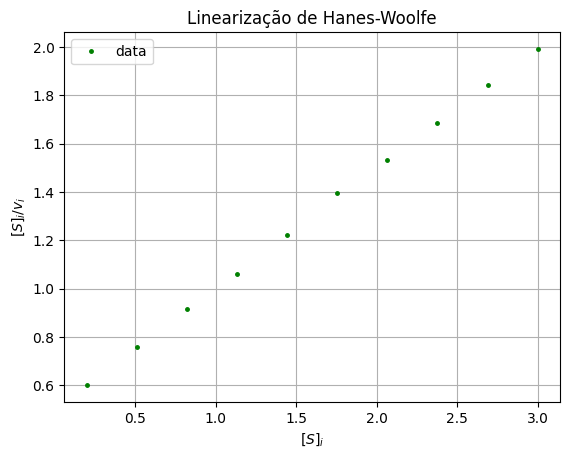

In [16]:
# Hanes-Woolfe mean of replicates with linear regression
#shw = np.repeat(s.reshape(-1,1),v.shape[1],axis=1)
shw = s
vhw = v.mean(axis=1)
#vhw = v[:,0]
vhw = s / vhw
#plt.errorbar(s,Km/Vmax+s/Vmax,fmt="k-",ecolor='r',xerr=0,
#             yerr=vhw.std(axis=1),capsize=2)
plt.plot(s,vhw,"g.",ms=5,label="data")
#plt.hlines(0.5,0,0.5,linestyle="dashed")
#plt.vlines(0.5,0,0.5,linestyle="dashed")
plt.legend()
plt.ylabel("$[S]_i/v_i$")
plt.xlabel("$[S]_i$")
plt.title("Linearização de Hanes-Woolfe")
plt.show()

Hanes-Woolf estimats:
    Km = 1.009, Vmax= 2.006, R = 0.9999


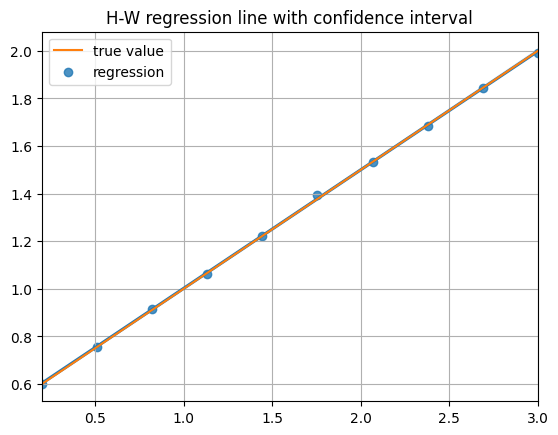

In [17]:
# Hanes-Woolf regression with confidence interval
shw = s
vhw = v.mean(axis=1)
#vhw = v[:,0]
vhw = s / vhw
regplot(s,vhw,label="regression")
m, b,r,_,_ = linregress(s,vhw)
_ = plt.title("H-W regression line with confidence interval")
if generate_data:
    plt.plot(s,s/MM(Km,Vmax,s),label="true value")
plt.legend()
#print(m,b,r)
#print(1/m,b/m)
HW_Km = b/m
HW_Vmax = 1/m
print("Hanes-Woolf estimats:")
print("    Km = {:5.3f}, Vmax= {:5.3f}, R = {:.4f}".format(HW_Km,HW_Vmax,r))

df_estimates['H-W'] = HW_Km, HW_Vmax

Computing 45 intersections
Direct Linear plot estimates:
    Km = 1.006, Vmax= 2.007


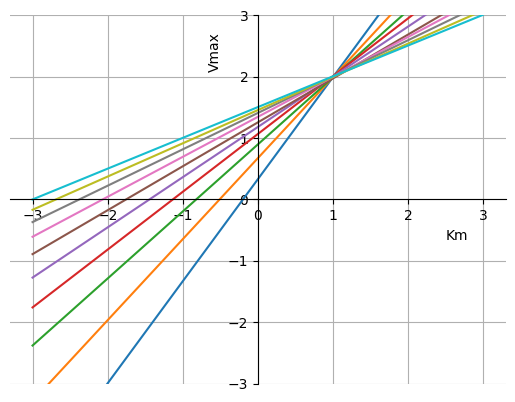

In [18]:
# Eisenthal Cornish-Bowden direct linear plot
vm = v.mean(axis=1)
x = np.arange(-s.max(),s.max(),0.01)
int_Vmax = []
int_Km = []
mmlines = np.vstack((vm/s,vm)).T
n_int = len(s)*(len(s)-1)//2
#Km_int = np.zeros(n_int)
#Vmax_int = np.zeros(n_int)

for m, b in mmlines:
  plt.plot(x,m*x+b)

print("Computing {:d} intersections".format(n_int))
for i in range(mmlines.shape[0]):
  for j in range(i):
    m1, b1 = mmlines[i]
    m2, b2 = mmlines[j]
    x = (b2-b1)/(m1-m2)
    y = (b2*m1-b1*m2)/(m1-m2)
    int_Km.append(x)
    int_Vmax.append(y)
    #print(x,y)
    #pass
    #print(i,j,mmlines[i],mmlines[j])rray python

ax = plt.gca()
ax.axis([-1.1*s.max(),1.1*s.max(),-2*vm.max(),2*vm.max()])
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel("Km",x=0.9)
ax.set_ylabel("Vmax",y=0.9)
ECB_Km = np.median(int_Km)
ECB_Vmax = np.median(int_Vmax)
print("Direct Linear plot estimates:") 
print("    Km = {:5.3f}, Vmax= {:5.3f}".format(ECB_Km, ECB_Vmax))
df_estimates['E-CB'] = ECB_Km, ECB_Vmax

Exact non-linear estimates at constant relative error:
    Km = 1.003, Vmax= 2.001


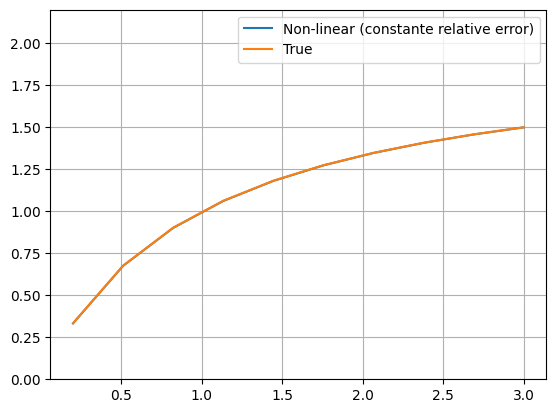

In [19]:
# Non-linear least square fitting (constant relative error)
# Johansen and Lumry
D = (vm*vm / s / s).sum()*vm.sum()-(vm*vm/s).sum()*(vm/s).sum()
JL_Vmax = ((vm*vm / s / s).sum()*(vm*vm).sum()-((vm*vm/s).sum())**2) / D
JL_Km = ((vm*vm).sum()*(vm/s).sum()-(vm*vm/s).sum()*vm.sum()) / D
plt.plot(s,MM(JL_Km,JL_Vmax,s),label = "Non-linear (constante relative error)")
plt.plot(s,MM(Km,Vmax,s),label="True")
plt.legend()
plt.ylim(0,1.1*Vmax)
print("Exact non-linear estimates at constant relative error:")
print("    Km = {:5.3f}, Vmax= {:5.3f}".format(JL_Km, JL_Vmax))
df_estimates['JL'] = JL_Km, JL_Vmax

In [20]:
df_estimates

,True,L-B,H-W,E-CB,JL
Km,1,1.001,1.009,1.006,1.003
Vmax,2,1.999,2.006,2.007,2.001


The error in the estimates is computed using the experimental variance:

$$ \sigma_{exp}^2 = \frac{\widehat{SS}}{(n-2)}$$

where $\widehat{SS}$ is the weighted sum of squares:

$$ \widehat{SS} = \sum w (1/v-1/\hat v)^2  $$

for constant relative error the weights are $w_i = v_i^2$, and for constant error they are $ w_i = \hat v^3v$ .

In [21]:
# Compute the experimental variance
v_hat = MM(JL_Km, JL_Vmax,s)
exp_var = (vm*vm*(1/vm - 1/v_hat)**2).sum() / (npoints-2) 
Vmax_var = (JL_Vmax)**4 * exp_var**2 * (vm*vm / s / s).sum() 
Vmax_var = Vmax_var / ((vm*vm / s / s).sum() * (vm*vm).sum() - ((vm*vm/s).sum())**2)           
Vmax_var

2.4218374328558794e-09

In [22]:
(((1/vm - 1/v_hat)**2)*vm*vm).sum() / 8

2.91650680251137e-05

In [23]:
 D = (vm*vm / s / s).sum()*vm.sum()-(vm*vm/s).sum()*(vm/s).sum()

In [24]:
B = (vm*vm).sum()*(vm/s).sum()-(vm*vm/s).sum()*vm.sum()

In [25]:
#A/D,B/D

#### Simple linear regression computations

In [26]:
# Computation of simple linear regression
mm = np.cov(s,vhw,ddof=0)[1,0]/s.var(ddof=0)
bb = vhw.mean()-s.mean()*mm
mm,m,bb,b

(0.49847025774202963,
 0.5020125833420105,
 0.5031604530384319,
 1.5060377500260316)

In [27]:
((s*vhw).sum() - s.sum()*vhw.sum())/10, np.cov(s,vhw,ddof=0)[1,0]
vhw

array([0.60082471, 0.75677655, 0.91461891, 1.06064935, 1.22139385,
       1.39607614, 1.53417772, 1.68570935, 1.84492015, 1.99198194])

In [28]:
(s*vhw).mean()-s.mean()*vhw.mean(),np.cov(s,vhw,ddof=0)[1,0]

(0.39803773173770995, 0.3980377317377096)

In [29]:
(s*vhw).sum() - s.sum()*vhw.sum()

-183.32227530392075

In [30]:
(s*vhw).sum() /10 - (s.sum()*vhw.sum())/10 /10

0.39803773173770995